In [8]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import time
from matplotlib import colors as mcolours
plt.style.use('ggplot')
%matplotlib inline

In [9]:
font_size = 15
matplotlib.rc('axes', edgecolor='black')
sns.set(font_scale=font_size/10)

def save_fig(fig, name):
    fig.savefig("../img/{}.pdf".format(name))

In [10]:
xvector_dim = 512
lang_names = ["AR", "BG", "CH", "CR", "CZ", "FR", "GE", "JA", "KO", "PL", 
              "PO", "RU", "SP", "SW", "TA", "TH", "TU", "WU", "VN"]
# slavic: "o"
# semitic: "v"
# sinitic: "P"
# italic: "*"
# germanic: "p"
# japonic: "X"
# koreanic: "d"
# tamil: "s"
# kra-dai: "<"
# turkic: "^"
# vietic: ">"

lang_properties = {
    "AR": ["dark sage",    "v"],
    "BG": ["aquamarine",   "o"],
    "CH": ["indigo",       "P"],
    "CR": ["brick red",    "o"],
    "CZ": ["sandy brown",  "o"],
    "FR": ["gray",         "*"],
    "GE": ["dark green",   "p"],
    "JA": ["dark peach",   "X"],
    "KO": ["salmon",       "d"],
    "PL": ["gold",         "o"],
    "PO": ["green yellow", "*"],
    "RU": ["dark orange",  "o"],
    "SP": ["navy blue",    "*"],
    "SW": ["black",        "p"],
    "TA": ["red",          "s"],
    "TH": ["hot pink",     "<"],
    "TU": ["dark red",     "^"],
    "WU": ["steel blue",   "P"],
    "VN": ["brown orange", ">"]
}
feat_cols = [str(i+1) for i in range(xvector_dim)]
col_names = ["language"] + feat_cols

In [11]:
def read_xvectors(filepath):
    df = pd.read_csv(filepath, sep=';', names=col_names)
    return df

In [12]:
def do_pca(df, n_comps=100):
    pca = PCA(n_components=n_comps)
    pca_result = pca.fit_transform(df[feat_cols].values)
    print('Cumulative explained variation for {} principal components: {:.3f}'\
          .format(n_comps, np.sum(pca.explained_variance_ratio_)))

    pca_cols = []
    for i in range(n_comps):
        idx = "pca" + str(i)
        pca_cols.append(idx)
        df[idx] = pca_result[:,i]
    
    return df, pca_cols

In [16]:
def do_tsne(df, row_selector, cols, num_samples=None):
    if num_samples is None:
        num_samples = len(row_selector)
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(df.loc[row_selector[:num_samples], cols].values)
    print('t-SNE done! Time elapsed: {:.1f} seconds'.format(time.time()-time_start))
    df_tsne = df.loc[row_selector[:num_samples],:].copy()
    df_tsne['x-tsne'] = tsne_results[:,0]
    df_tsne['y-tsne'] = tsne_results[:,1]
    return df_tsne

In [14]:
def plot_tsne(df):
    colour_mapping = mcolours.get_named_colors_mapping()
    colours = [colour_mapping["xkcd:" + lang_properties[l][0]] for l in lang_names]
    markers = [lang_properties[l][1] for l in lang_names]

    plt.figure(figsize=(11,11), frameon=True)
    ax = plt.gca()
    plot = sns.scatterplot(x='x-tsne', y='y-tsne', hue="language", data=df, 
                           palette=colours, hue_order=lang_names, style="language", 
                           markers=markers, style_order=lang_names, s=50, 
                           edgecolor="#dddddd00", linewidth=0.3, alpha=0.8, ax=ax)

    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
    ax.tick_params(axis='both', which='both', size=6, labelcolor='black', color='black', labelsize=font_size)
    ax.set_facecolor('#FFFFFF')
    legend = ax.legend(loc=0, frameon=1, prop={'size': font_size})
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    for legobj in legend.legendHandles:
        legobj.set_linewidth(2.0)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    plt.tight_layout()
    fig = plot.get_figure()
    return fig

Cumulative explained variation for 100 principal components: 0.992
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20347 samples in 0.157s...
[t-SNE] Computed neighbors for 20347 samples in 115.198s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20347
[t-SNE] Computed conditional probabilities for sample 2000 / 20347
[t-SNE] Computed conditional probabilities for sample 3000 / 20347
[t-SNE] Computed conditional probabilities for sample 4000 / 20347
[t-SNE] Computed conditional probabilities for sample 5000 / 20347
[t-SNE] Computed conditional probabilities for sample 6000 / 20347
[t-SNE] Computed conditional probabilities for sample 7000 / 20347
[t-SNE] Computed conditional probabilities for sample 8000 / 20347
[t-SNE] Computed conditional probabilities for sample 9000 / 20347
[t-SNE] Computed conditional probabilities for sample 10000 / 20347
[t-SNE] Computed conditional probabilities for sample 11000 / 20347
[t-SNE] Computed conditional probabilities for s

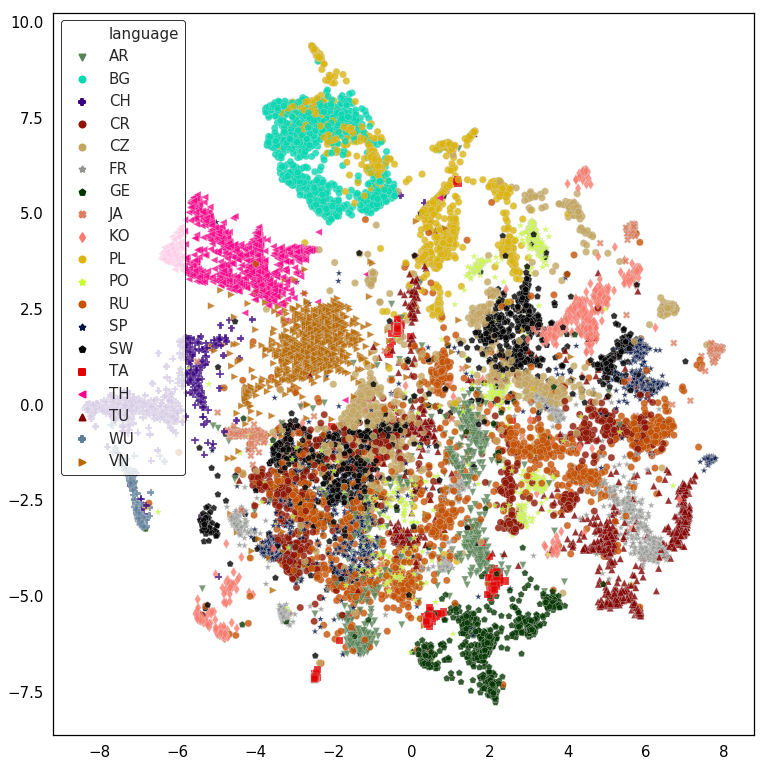

In [18]:
filepath = "xvectors/pitch_eval/xvector.scp.csv"
df = read_xvectors(filepath)
rndperm = np.random.permutation(df.shape[0])
df, pca_cols = do_pca(df)
df = do_tsne(df, rndperm, pca_cols)
fig = plot_tsne(df)
save_fig(fig, name="tsne-pitch")
plt.show()